In [1]:
import os
import math
import pefile
import pandas as pd
from tqdm import tqdm

In [2]:
def calculate_entropy(data):
    if not data:
        return 0.0
    entropy = 0
    byte_counts = [0] * 256
    for byte in data:
        byte_counts[byte] += 1
    for count in byte_counts:
        if count == 0:
            continue
        p = count / len(data)
        entropy -= p * math.log2(p)
    return entropy


In [3]:
import os
import numpy as np
import pefile

def extract_features(filepath):
    try:
        pe = pefile.PE(filepath)

        with open(filepath, "rb") as f:
            file_bytes = f.read()

        entropy = calculate_entropy(file_bytes)

        num_sections = len(pe.sections)
        section_entropies = [section.get_entropy() for section in pe.sections]
        mean_section_entropy = np.mean(section_entropies)
        max_section_entropy = np.max(section_entropies)
        min_section_entropy = np.min(section_entropies)

        has_debug = hasattr(pe, 'DIRECTORY_ENTRY_DEBUG')
        has_signature = hasattr(pe, 'DIRECTORY_ENTRY_SECURITY')
        has_tls = hasattr(pe, 'DIRECTORY_ENTRY_TLS')
        has_resources = hasattr(pe, 'DIRECTORY_ENTRY_RESOURCE')
        has_imports = hasattr(pe, 'DIRECTORY_ENTRY_IMPORT')
        has_exports = hasattr(pe, 'DIRECTORY_ENTRY_EXPORT')

        num_imports = 0
        num_dlls = 0
        if has_imports:
            for entry in pe.DIRECTORY_ENTRY_IMPORT:
                num_dlls += 1
                num_imports += len(entry.imports)

        num_exports = len(pe.DIRECTORY_ENTRY_EXPORT.symbols) if has_exports else 0

        num_relocations = sum(len(entry.entries) for entry in pe.DIRECTORY_ENTRY_BASERELOC) if hasattr(pe, 'DIRECTORY_ENTRY_BASERELOC') else 0
        num_symbols = pe.FILE_HEADER.NumberOfSymbols or 0

        machine = pe.FILE_HEADER.Machine
        characteristics = pe.FILE_HEADER.Characteristics
        entry_point = pe.OPTIONAL_HEADER.AddressOfEntryPoint
        subsystem = pe.OPTIONAL_HEADER.Subsystem

        major_linker = pe.OPTIONAL_HEADER.MajorLinkerVersion
        major_os = pe.OPTIONAL_HEADER.MajorOperatingSystemVersion
        major_image = pe.OPTIONAL_HEADER.MajorImageVersion
        major_subsystem = pe.OPTIONAL_HEADER.MajorSubsystemVersion

        return [
            entropy,
            mean_section_entropy, max_section_entropy, min_section_entropy,
            num_sections, num_imports, num_exports, num_dlls,
            int(has_debug), int(has_signature), int(has_tls), int(has_resources),
            int(has_imports), int(has_exports),
            num_relocations, num_symbols,
            machine, characteristics, entry_point, subsystem,
            major_linker, major_os, major_image, major_subsystem
        ]

    except Exception as e:
        print(f"❌ Error en: {filepath} → {e}")
        return None

In [4]:
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from threading import Lock

columns = [
    "entropy",
    "mean_section_entropy", "max_section_entropy", "min_section_entropy",
    "num_sections", "num_imports", "num_exports", "num_dlls",
    "has_debug", "has_signature", "has_tls", "has_resources",
    "has_imports", "has_exports",
    "num_relocations", "num_symbols",
    "machine", "characteristics", "entry_point", "subsystem",
    "major_linker", "major_os", "major_image", "major_subsystem"
]

def create_dataset_parallel(dataset_path="dataset", max_workers=6):
    print("🟡 Iniciando extracción paralela de features...")
    start_time = time.time()
    rows = []
    lock = Lock()
    counter = [0]

    def process_file(label, filepath, total):
        features = extract_features(filepath)
        with lock:
            counter[0] += 1
            done = counter[0]
            if done % 100 == 0 or done == total:
                print(f"✅ Procesados {done}/{total} archivos")
        if features:
            return dict(zip(columns + ["label"], features + [label]))
        return None

    futures = []
    total_files = 0
    for label, subfolder in enumerate(["clean", "malware"]):
        folder = os.path.join(dataset_path, subfolder)
        files = os.listdir(folder)
        print(f"🔍 Encontrados {len(files)} archivos en '{subfolder}/'")
        total_files += len(files)
        for filename in files:
            filepath = os.path.join(folder, filename)
            futures.append((label, filepath))

    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_info = {
            executor.submit(process_file, label, filepath, total_files): (label, filepath)
            for label, filepath in futures
        }

        for future in tqdm(as_completed(future_to_info), total=total_files, desc="📦 Extrayendo features"):
            result = future.result()
            if result:
                results.append(result)

    elapsed = time.time() - start_time
    print(f"\n✅ Finalizado en {elapsed:.2f} segundos. Total archivos válidos: {len(results)}")

    df = pd.DataFrame(results)
    return df


In [5]:
extract_features("dataset/clean/rasautou_-8519207558448359367.exe")

[5.315804999439292,
 np.float64(3.341381681280666),
 np.float64(5.836009321931579),
 np.float64(0.16476501235057214),
 6,
 62,
 0,
 7,
 1,
 0,
 0,
 1,
 1,
 0,
 292,
 0,
 332,
 258,
 10512,
 3,
 14,
 10,
 10,
 10]

In [ ]:
df = create_dataset_parallel("dataset", max_workers=6)
df.to_csv("malware_dataset.csv", index=False)
print("✅ Dataset guardado en 'malware_dataset.csv'")

🟡 Iniciando extracción paralela de features...
🔍 Encontrados 4738 archivos en 'clean/'
🔍 Encontrados 4738 archivos en 'malware/'


📦 Extrayendo features:   0%|          | 0/9476 [00:00<?, ?it/s]

/home/penguin/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/penguin/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


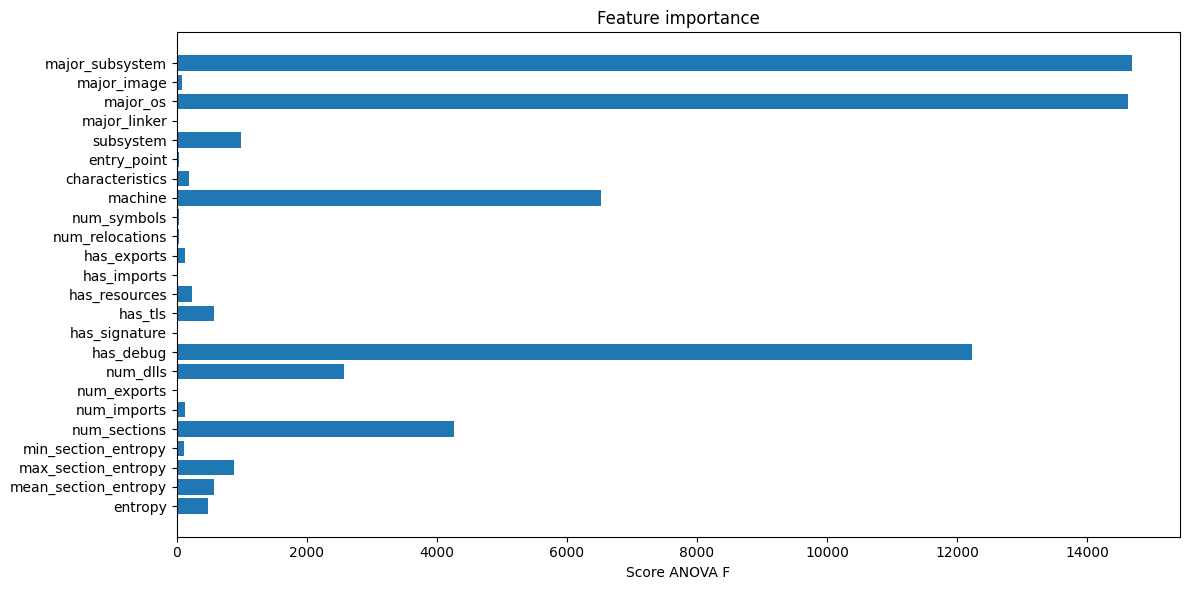

,Feature,Score
23,major_subsystem,14696.741863
21,major_os,14637.355765
8,has_debug,12226.716401
16,machine,6517.703883
4,num_sections,4267.798982
7,num_dlls,2571.613692
19,subsystem,979.941675
2,max_section_entropy,876.416453
10,has_tls,565.267699
1,mean_section_entropy,564.024437


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("malware_dataset.csv")

# Prepare X and y
X = df.drop("label", axis=1)
y = df["label"]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Selección estadística
selector = SelectKBest(score_func=f_classif, k="all")
selector.fit(X_scaled, y)

# Visualize
scores = selector.scores_
features = X.columns

plt.figure(figsize=(12, 6))
plt.barh(features, scores)
plt.xlabel("Score ANOVA F")
plt.title("Feature importance")
plt.tight_layout()
plt.show()

# Display table
ranking = pd.DataFrame({
    "Feature": features,
    "Score": scores
}).sort_values(by="Score", ascending=False)

display(ranking)


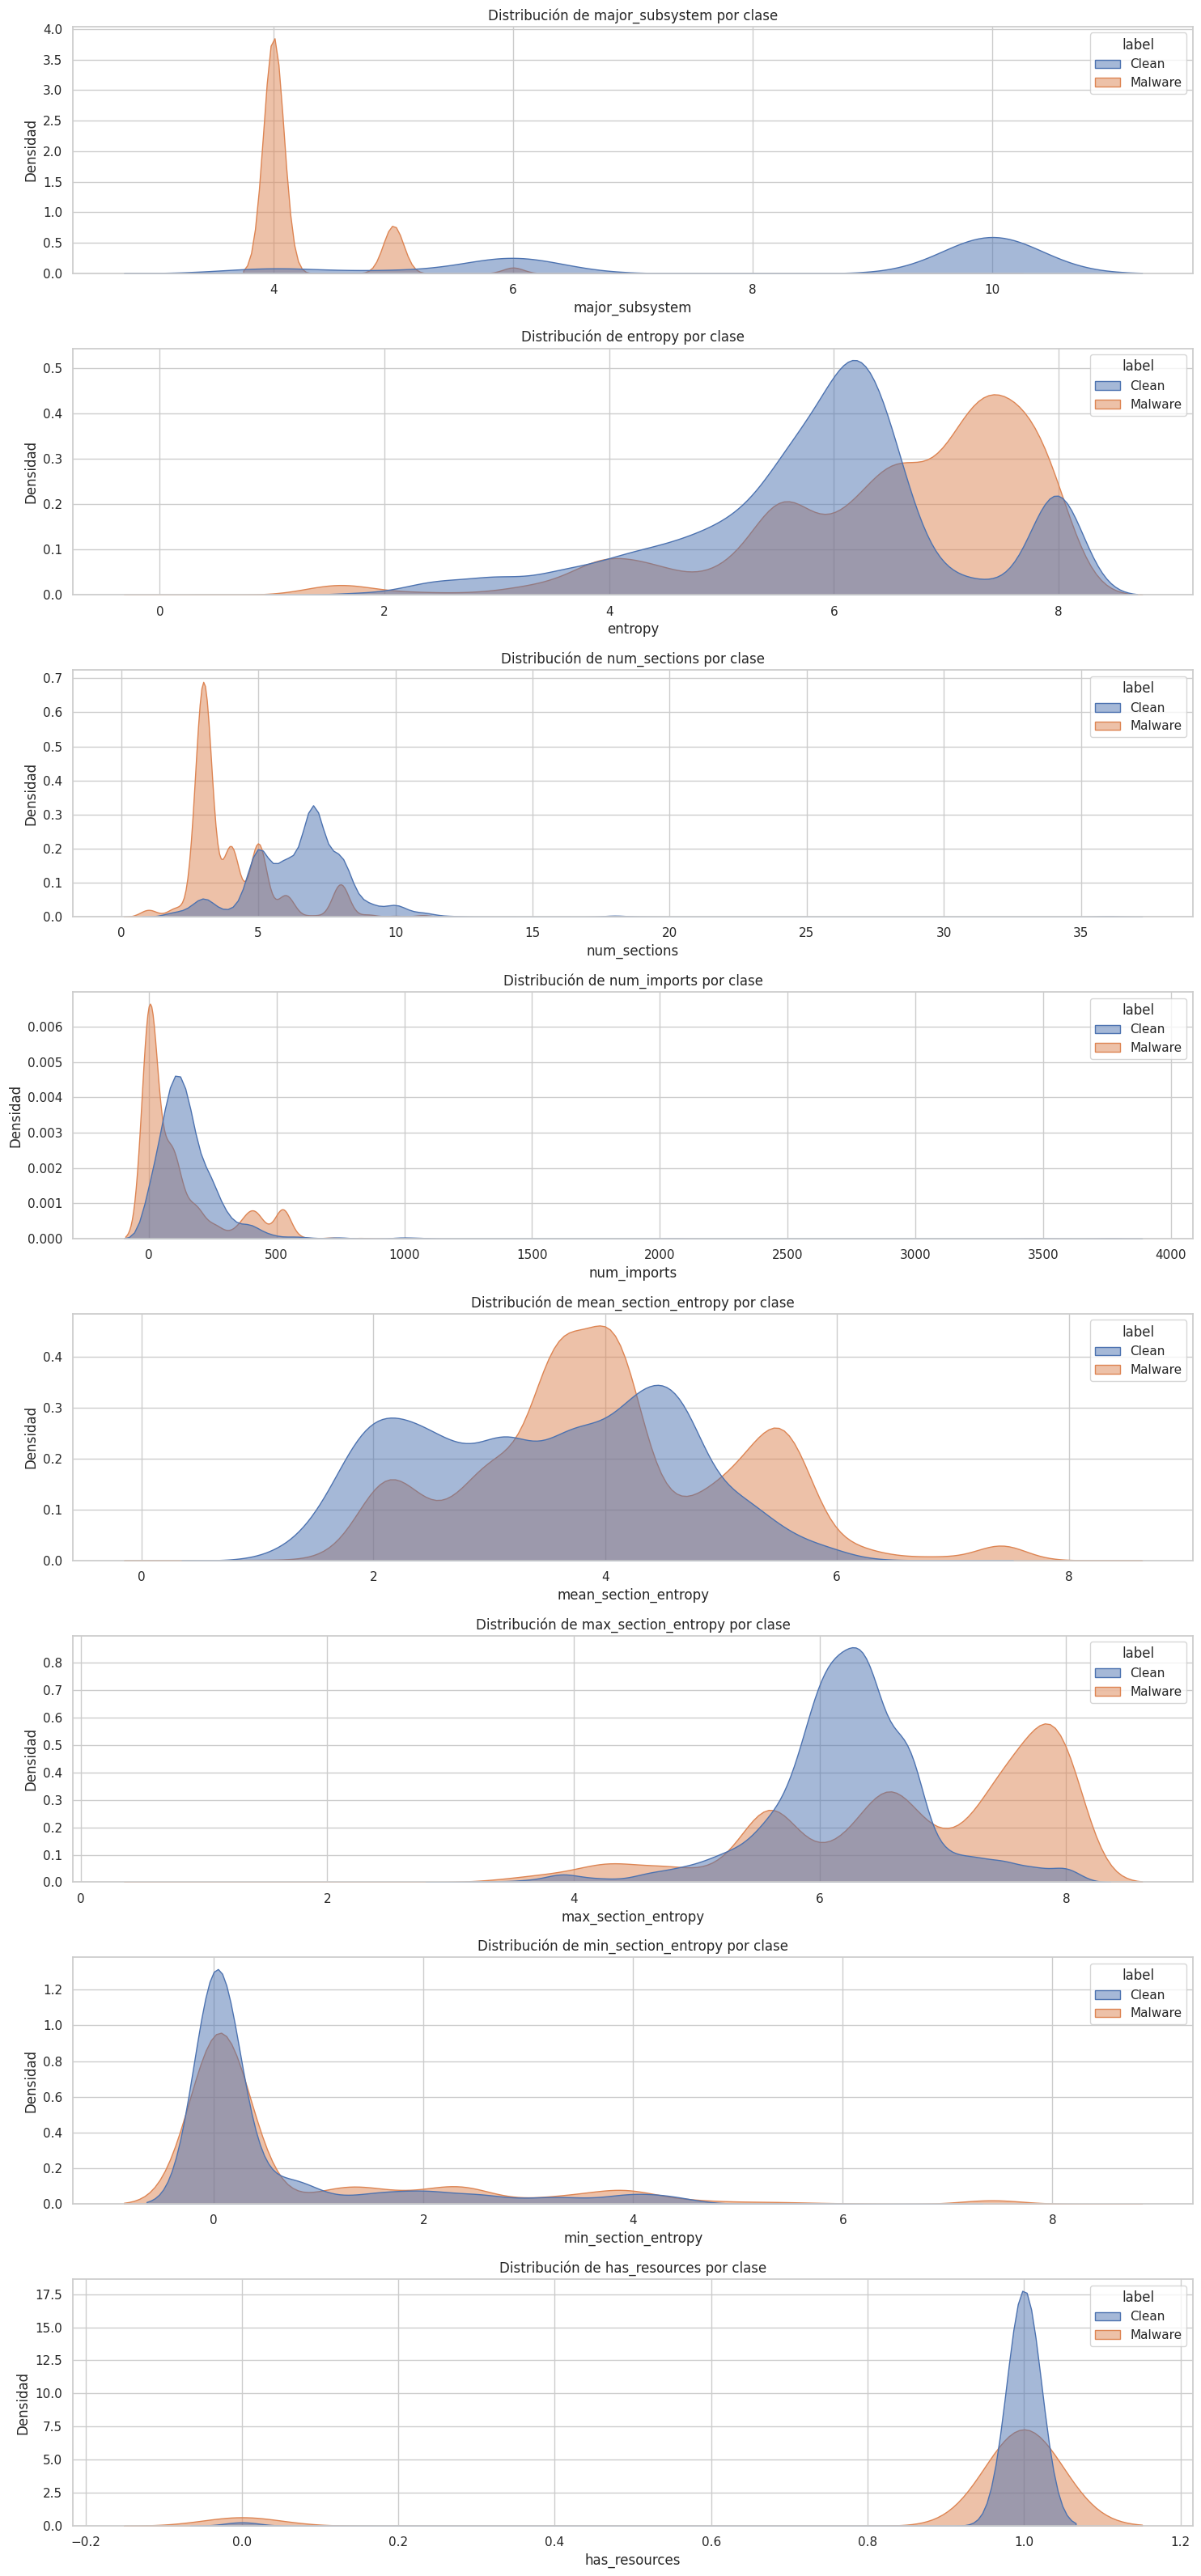

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

features_to_plot = [
    "major_subsystem", "entropy", "num_sections", "num_imports",
    "mean_section_entropy", "max_section_entropy", "min_section_entropy", "has_resources"
]

df_viz = df.copy()
df_viz["label"] = df_viz["label"].map({0: "Clean", 1: "Malware"})

plt.figure(figsize=(15, 4 * len(features_to_plot)))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(len(features_to_plot), 1, i)
    sns.kdeplot(data=df_viz, x=feature, hue="Label", fill=True, common_norm=False, alpha=0.5)
    plt.title(f"Distribución de {feature} por clase")
    plt.xlabel(feature)
    plt.ylabel("Densidad")

plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar features y etiquetas
X = df.drop("label", axis=1)
y = df["label"]

# Dividir en train/test (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Escalar (opcional para modelos como SVM o redes neuronales, no esencial para RandomForest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


NameError: name 'df' is not defined

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# Selector
selector = SelectKBest(score_func=f_classif, k="all")
selector.fit(X_train_scaled, y_train)

# Resultados
scores = selector.scores_
features = X.columns

# Visualizar en gráfico
plt.figure(figsize=(10, 6))
plt.barh(features, scores)
plt.xlabel("Score ANOVA F")
plt.title("Importancia estadística de cada feature")
plt.tight_layout()
plt.show()

# Mostrar tabla ordenada
ranking = pd.DataFrame({
    "Feature": features,
    "Score": scores
}).sort_values(by="Score", ascending=False)

display(ranking)


NameError: name 'X_train_scaled' is not defined

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Entrenar modelo
clf = RandomForestClassifier(n_estimators=1000, random_state=12)
clf.fit(X_train_scaled, y_train)

# Predecir
y_pred = clf.predict(X_test_scaled)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Clean", "Malware"]))


[[948   0]
 [  4 943]]
              precision    recall  f1-score   support

       Clean       1.00      1.00      1.00       948
     Malware       1.00      1.00      1.00       947

    accuracy                           1.00      1895
   macro avg       1.00      1.00      1.00      1895
weighted avg       1.00      1.00      1.00      1895



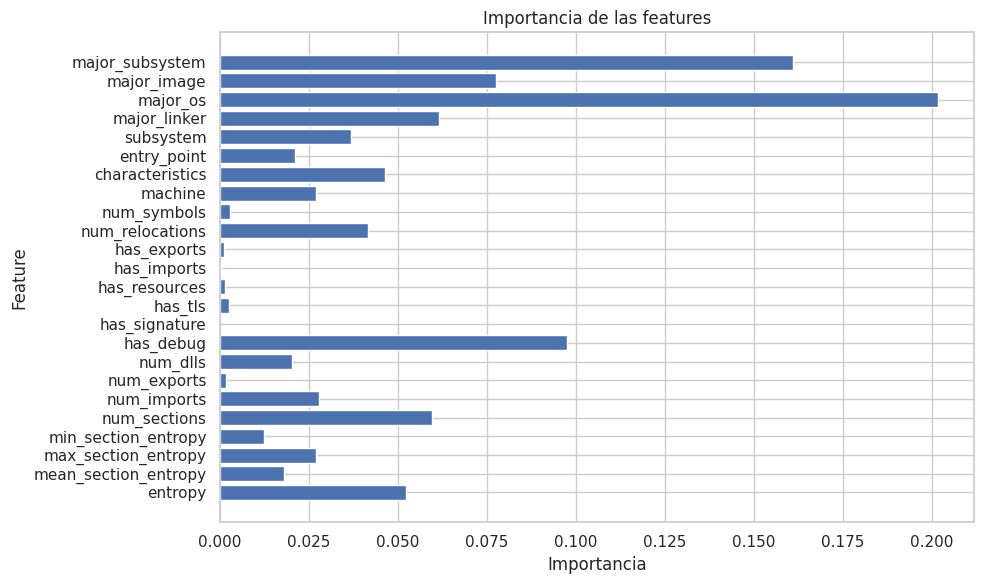

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

importances = clf.feature_importances_
features = X.columns

# Visualizar
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Importancia de las features")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [102]:
import joblib

# Guarda el modelo entrenado
joblib.dump(clf, "modelo_random_forest.pkl")

# Guarda el escalador (StandardScaler)
joblib.dump(scaler, "scaler.pkl")

print("✅ Modelo y scaler guardados correctamente.")

✅ Modelo y scaler guardados correctamente.


In [104]:
def predict_exe(filepath):
    features = extract_features(filepath)
    if not features:
        print("❌ No se pudieron extraer las características del archivo.")
        return

    # Convertir a DataFrame de una sola fila
    import pandas as pd
    X_single = pd.DataFrame([features], columns=[
        "entropy", "mean_section_entropy", "max_section_entropy", "min_section_entropy",
        "num_sections", "num_imports", "num_exports", "num_dlls",
        "has_debug", "has_signature", "has_tls", "has_resources",
        "has_imports", "has_exports", "num_relocations", "num_symbols",
        "machine", "characteristics", "entry_point", "subsystem",
        "major_linker", "major_os", "major_image", "major_subsystem"
    ])

    # Escalar y predecir
    X_scaled = scaler.transform(X_single)
    prediction = clf.predict(X_scaled)[0]
    proba = clf.predict_proba(X_scaled)[0]

    # Mostrar resultados
    label = "Malware" if prediction == 1 else "Clean"
    print(f"🔍 Predicción: {label}")
    print(f"📊 Probabilidades → Clean: {proba[0]*100:.2f}% | Malware: {proba[1]*100:.2f}%")


In [108]:
predict_exe("/home/penguin/edge.exe")

🔍 Predicción: Malware
📊 Probabilidades → Clean: 41.30% | Malware: 58.70%
